In [1]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
csv.field_size_limit(100000000)
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.4f}'.format

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# **Logostic Regression** 
## *(1) TweetsCov19*
#### (Content + User Features)

In [14]:
path = '../data/df_tweetscov19_sample_200000_23_v2.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num', 'Mentions_num', 'URLs_num', 'tweet_political_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1201881191831478274,636d167ce4b8f77824418196e91fed1b,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.4675,True
1,1180274914248536065,1c13163376be1575ec47744214e470c2,0,0,0,2,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.2258,True
2,1248838077675720705,a7f6502ef90a369910b8efd89977b0fe,0,0,0,5,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.1120,True
3,1265033539487227904,ccf1364cfe318e307960285ee352981a,0,0,4,0,0,0.0000,0.0000,0.0000,1.0000,0.0000,-1.0000,5,1,0.2000,0.7878,True
4,1248513384028549120,43bbe33dbb90262a53eb12791a7f3a0d,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.0000,True


In [15]:
#Quantile
q = [0.1, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99]
print(len(q))
for i in range(0,len(q)):
    print("{:.2f}".format(q[i]), '=> ',df_tweetscov19_user['user_deleted_tweets'].quantile(q[i]))


7
0.10 =>  0.0
0.50 =>  1.0
0.75 =>  2.0
0.90 =>  7.0
0.95 =>  12.0
0.98 =>  17.0
0.99 =>  20.0


In [16]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1253543952554262528,cde9b84588bc21b495ecf8ceb19d46f3,0,0,1,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,131,0,0.0000,0.5000,False
1,1261736485214027776,34df99aaf53d989bed631022446d0fe5,0,0,0,4,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.1827,True
2,1220724088844574721,340e1f2698006936a33d92dfc209dabb,9,27,3,1,1,0.0000,0.0000,0.0000,-0.7692,0.0000,-0.9231,46,1,0.0217,0.9889,True
3,1215984216497770497,4f21024ddb90ee8d0dc2e3c0e74f22fb,3,0,1,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,74,0,0.0000,0.3346,False
4,1265551288575590400,6c9f5be69af36f801a7bcb852d2d882b,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,0,0.0000,0.6364,False


In [17]:
df_tweetscov19_del = df_tweetscov19_user[df_tweetscov19_user['Is_deleted']==True]
df_tweetscov19_undel = df_tweetscov19_user[df_tweetscov19_user['Is_deleted']==False]

In [18]:
def plot_paiplot(df, hue, titel): 
   
    #plt.rcParams["figure.figsize"] = [6,4]
    #fig, ax = plt.subplots()
    sns.pairplot(df, hue = hue)

    #ax.set_ylabel('Dataframe')

    #ax.set_xlabel('Deletion ratio', fontsize=12)
    #plt.margins(0.02)
    #fig.tight_layout()
    #plt.show()

    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/log_reg/'+titel+'.jpg')

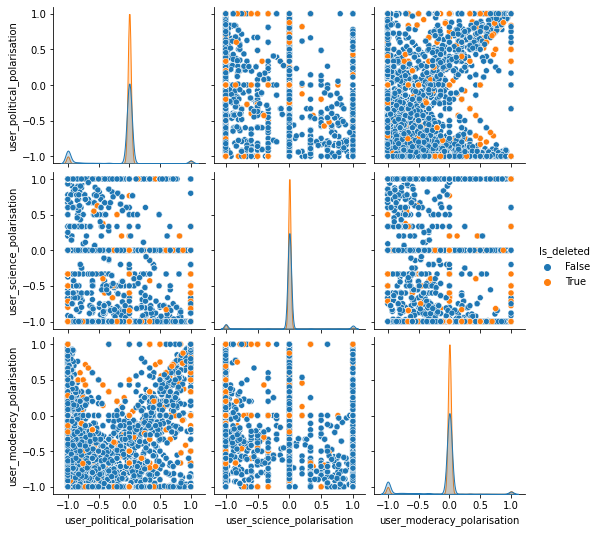

In [19]:
df = df_tweetscov19_user[['Is_deleted', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetsocv19_Retweet_favoriet_sentiment')

In [20]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num',
       'Mentions_num', 'URLs_num', 'tweet_political_polarisation',
       'tweet_science_polarisation', 'tweet_moderacy_polarisation',
       'user_political_polarisation', 'user_science_polarisation',
       'user_moderacy_polarisation', 'user_posted_tweets',
       'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation',
       'Is_deleted'],
      dtype='object')

In [21]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)

In [22]:
df_tweetscov19_user.tail()

,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
199995,1245875497705201664,36c93870cf0e33c1dcd10adb4a343a2d,111,509,0,1,0,0.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,28,0,0.0000,0.5760,0
199996,1199183360959975424,e728964ea124e7e93c956bb0da31b512,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.4534,1
199997,1238944003388817409,47cc736f484e364b2e537e24de8cf70b,1,2,1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.2816,0
199998,1247055455148560386,93e046285a9a3beb77e55038944da923,10,142,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0.9945,0
199999,1187060446697705472,533aa314f60151b82339106dc798e923,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4,4,1.0000,0.5687,1


In [23]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio'])

In [24]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [25]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 12)
(200000,)


In [26]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 12)
(40000, 12)
(160000,)
(40000,)


In [39]:
def fit_log_reg(X,y):
    l_regression = LogisticRegression(random_state=20, solver = 'lbfgs')
    l_regression.fit(X,y)
    return l_regression

In [40]:
def test_log_reg(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [41]:
l_regression = fit_log_reg(X_train, y_train)

In [42]:
test_log_reg(l_regression, X_test,y_test)

Accuracy : 0.61175


In [43]:
y_pred = l_regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.54      0.58      1987
           1       0.60      0.69      0.64      2013

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000



In [44]:
def plot_confusion_matrix(confu_matrix, classes, titel):
    sns.heatmap(confu_matrix, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.53648717 0.46351283]
 [0.31395926 0.68604074]]


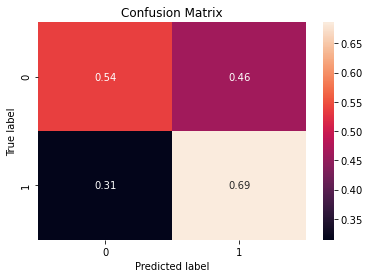

In [45]:
confusion_mx = confusion_matrix(y_test, y_pred)
confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
plot_confusion_matrix(confusion_mx, l_regression.classes_, 'Confusion Matrix')
print(confusion_mx)

In [7]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [47]:
clf_cv = LogisticRegression(random_state=20, solver = 'lbfgs')
print_cross_val_score(clf_cv, X, y)

 percision : 0.58 +/- 0.007
 f1        : 0.64 +/- 0.030
 recall    : 0.71 +/- 0.080


***

In [48]:
#Finding best DecisionTreeClassifier for detecting feature importances
param_grid = {'criterion':['gini','entropy'],
              'max_depth': range(1,10),
              'random_state' : [5, 10, 15],
              'min_samples_split' : range(1,10),
              'min_samples_leaf' : range(1,10)}

In [49]:
model = DecisionTreeClassifier()

DecisionTreeClassifier_clf = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [50]:
%%time
best_clf = DecisionTreeClassifier_clf.fit(X_train,y_train)

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits
Wall time: 1min 21s


In [51]:
best_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'random_state': 10}

****

In [58]:
def features_classifier_tweetscov19(X, y):

    decisionTC = DecisionTreeClassifier(random_state=10, criterion= 'entropy', max_depth = 6, min_samples_leaf= 3, min_samples_split= 8 )
    decisionTC.fit(X,y)
    
    column_feature = {}

    for i, c in enumerate(X):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = decisionTC.feature_importances_[i]
        
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    return df_column_feature.reset_index()

In [59]:
f_importances = features_classifier_tweetscov19( X, y)
f_importances

,index,Feature,importance
0,11,user_Reputation,0.4621
1,8,user_political_polarisation,0.1856
2,10,user_moderacy_polarisation,0.1416
3,4,URLs_num,0.0674
4,0,Retweets,0.0673
5,2,Hashtags_num,0.0453
6,1,Favorites,0.0139
7,9,user_science_polarisation,0.0067
8,3,Mentions_num,0.0061
9,6,tweet_science_polarisation,0.0039


In [60]:
f_importances = f_importances[f_importances['importance'] != 0.0]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'user_political_polarisation'
 'user_moderacy_polarisation' 'URLs_num' 'Retweets' 'Hashtags_num'
 'Favorites' 'user_science_polarisation' 'Mentions_num'
 'tweet_science_polarisation']


In [61]:
len(f_importances)

10

In [62]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(20000, 10)
(20000,)


***

In [63]:
param_grid = [{'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             {'C' : np.logspace(-4,4,20)},
             {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'ag', 'saga']},
             {'max_iter' : [100, 200, 500, 1000, 2500, 5000]}]

In [64]:
l_regression_GridS = LogisticRegression()

clf = GridSearchCV(l_regression_GridS, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [65]:
%%time
best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Wall time: 3.63 s


In [66]:
best_clf.best_estimator_

LogisticRegression(C=0.0018329807108324356)

In [42]:
best_clf.best_params_

{'solver': 'newton-cg'}

In [67]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.58 +/- 0.007
 f1        : 0.63 +/- 0.037
 recall    : 0.69 +/- 0.092


In [28]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.58 +/- 0.002
 f1        : 0.68 +/- 0.002
 recall    : 0.81 +/- 0.003


****************************************************************************
****************************************************************************

### Tweetscov19
#### (Conten only)

In [29]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [30]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 8)
(200000,)


In [31]:
f_importances = features_classifier_tweetscov19( X, y)
f_importances

NameError: name 'features_classifier_tweetscov19' is not defined

In [72]:
f_importances = f_importances[f_importances['importance'] != 0.0]
f_importances = f_importances.Feature.values

print(len(f_importances))
print(f_importances)

8
['Retweets' 'URLs_num' 'Hashtags_num' 'Favorites'
 'tweet_political_polarisation' 'Mentions_num'
 'tweet_moderacy_polarisation' 'tweet_science_polarisation']


In [73]:
X_new,y = get_X_y(df_tweetscov19_user, f_importances)

(20000, 8)
(20000,)


In [75]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.56 +/- 0.016
 f1        : 0.65 +/- 0.018
 recall    : 0.78 +/- 0.068


In [32]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.55 +/- 0.002
 f1        : 0.66 +/- 0.002
 recall    : 0.83 +/- 0.004


****************************************************************
****************************************************************

## *(2)Tweetskb*
### (Content + User feature)

In [33]:
path = '../data/df_tweetskb_sample_200000_9_v2.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num', 'Mentions_num', 'URLs_num', 'tweet_political_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted' ])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1223471572998074368,steven_leal54,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.4051,True
1,1213585161071280128,Brittan29273626,144,394,0,0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,1.0000,True
2,1186217177675902976,YuumaTsukumo,0,0,1,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.5548,True
3,1228371761416175616,jocelynlee_,2,4,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,2,1.0000,0.4786,True
4,1231907143835672577,StephanieKwinn,7,22,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5,4,0.8000,0.6074,True


In [34]:
#Quantile
q = [0.1, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99]
print(len(q))
for i in range(0,len(q)):
    print("{:.2f}".format(q[i]), '=> ',df_tweetskb_user['user_deleted_tweets'].quantile(q[i]))


7
0.10 =>  0.0
0.50 =>  1.0
0.75 =>  2.0
0.90 =>  4.0
0.95 =>  5.0
0.98 =>  7.0
0.99 =>  8.0


In [35]:
df_tweetskb_user = df_tweetskb_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape:  (200000, 18)


,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1245224881903611915,flak2kay,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.5134,True
1,1252599298803539969,BabyHomie_,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6,6,1.0000,0.5131,True
2,1217068728870952961,jueunbebe,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7,7,1.0000,0.5467,True
3,1219069327992709120,basedmorrison,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,1,0.5000,0.5842,True
4,1190991767799304195,thoughtsofneb,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.1707,True


In [36]:
df_tweetskb_user.Username.unique().size

191791

In [37]:
df_tweetskb_del = df_tweetskb_user[df_tweetskb_user['Is_deleted']==True]
df_tweetskb_undel = df_tweetskb_user[df_tweetskb_user['Is_deleted']==False]

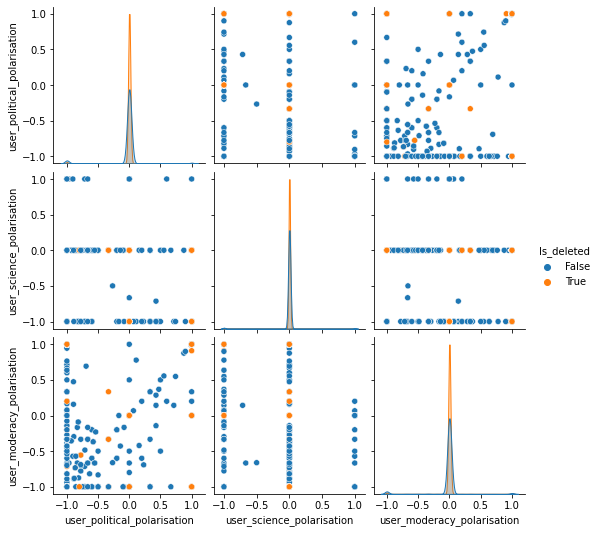

In [87]:
df = df_tweetskb_user[['Is_deleted',  'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation']]
plot_paiplot(df, 'Is_deleted', 'pairplot_tweetskb_politic_science_moderacy')

In [38]:
features = df_tweetskb_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Hashtags_num',
       'Mentions_num', 'URLs_num', 'tweet_political_polarisation',
       'tweet_science_polarisation', 'tweet_moderacy_polarisation',
       'user_political_polarisation', 'user_science_polarisation',
       'user_moderacy_polarisation', 'user_posted_tweets',
       'user_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation',
       'Is_deleted'],
      dtype='object')

In [39]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 1, 0)
df_tweetskb_user.head()

,Tweet_Id,Username,Retweets,Favorites,Hashtags_num,Mentions_num,URLs_num,tweet_political_polarisation,tweet_science_polarisation,tweet_moderacy_polarisation,user_political_polarisation,user_science_polarisation,user_moderacy_polarisation,user_posted_tweets,user_deleted_tweets,user_Deletion_ratio,user_Reputation,Is_deleted
0,1245224881903611915,flak2kay,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3,3,1.0000,0.5134,1
1,1252599298803539969,BabyHomie_,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6,6,1.0000,0.5131,1
2,1217068728870952961,jueunbebe,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7,7,1.0000,0.5467,1
3,1219069327992709120,basedmorrison,0,0,0,1,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2,1,0.5000,0.5842,1
4,1190991767799304195,thoughtsofneb,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,1,1.0000,0.1707,1


In [40]:
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_posted_tweets', 'user_deleted_tweets', 'user_Deletion_ratio'])

In [41]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 12)
(200000,)


In [42]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 12)
(40000, 12)
(160000,)
(40000,)


***

In [94]:
#Finding best DecisionTreeClassifier for detecting the feature importances
param_grid = {'criterion':['gini','entropy'],
              'max_depth': range(1,10),
              'random_state' : [5, 10, 15],
              'min_samples_split' : range(1,10),
              'min_samples_leaf' : range(1,10)}

In [95]:
model = DecisionTreeClassifier()

DecisionTreeClassifier_clf = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [96]:
%%time
best_clf = DecisionTreeClassifier_clf.fit(X_train,y_train)

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits
Wall time: 1min 12s


In [97]:
best_clf.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 5}

In [98]:
def features_classifier_tweetskb(X, y):

    decisionTC = DecisionTreeClassifier(random_state=6, criterion= 'gini', max_depth = 4, min_samples_leaf=3, min_samples_split=2)
    decisionTC.fit(X,y)
    
    column_feature = {}

    for i, c in enumerate(X):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = decisionTC.feature_importances_[i]
        
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    return df_column_feature.reset_index()

In [99]:
f_importances = features_classifier_tweetskb( X, y)
f_importances

,index,Feature,importance
0,0,Retweets,0.3843
1,11,user_Reputation,0.2544
2,8,user_political_polarisation,0.1573
3,4,URLs_num,0.0988
4,3,Mentions_num,0.0966
5,1,Favorites,0.0065
6,10,user_moderacy_polarisation,0.0022
7,2,Hashtags_num,0.0000
8,5,tweet_political_polarisation,0.0000
9,6,tweet_science_polarisation,0.0000


In [100]:
f_importances = f_importances[f_importances['importance']!=0.0]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'user_Reputation' 'user_political_polarisation' 'URLs_num'
 'Mentions_num' 'Favorites' 'user_moderacy_polarisation']


In [101]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(20000, 7)
(20000,)


In [102]:
param_grid = [{'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             {'C' : np.logspace(-4,4,20)},
             {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'ag', 'saga']},
             {'max_iter' : [100, 200, 500, 1000, 2500, 5000]}]

In [103]:
l_regression_GridS = LogisticRegression()

best_clf = GridSearchCV(l_regression_GridS, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)

In [104]:
%%time
best_clf = best_clf.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Wall time: 5.65 s


In [105]:
best_clf.best_estimator_

LogisticRegression(C=0.0018329807108324356)

In [106]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.55 +/- 0.006
 f1        : 0.62 +/- 0.008
 recall    : 0.71 +/- 0.015


In [43]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.55 +/- 0.002
 f1        : 0.61 +/- 0.006
 recall    : 0.69 +/- 0.015


**********************************************************************
**********************************************************************

### Tweetskb
#### (Content only)

In [44]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [45]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 8)
(200000,)


In [46]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 8)
(40000, 8)
(160000,)
(40000,)


In [111]:
f_importances = features_classifier_tweetskb( X, y)
f_importances

,index,Feature,importance
0,0,Retweets,0.6350
1,4,URLs_num,0.1881
2,3,Mentions_num,0.0847
3,1,Favorites,0.0460
4,2,Hashtags_num,0.0294
5,5,tweet_political_polarisation,0.0168
6,6,tweet_science_polarisation,0.0000
7,7,tweet_moderacy_polarisation,0.0000


In [112]:
f_importances = f_importances[f_importances['importance'] != 0.0]
f_importances = f_importances.Feature.values
print(f_importances)

['Retweets' 'URLs_num' 'Mentions_num' 'Favorites' 'Hashtags_num'
 'tweet_political_polarisation']


In [113]:
X_new,y = get_X_y(df_tweetskb_user, f_importances)

(20000, 6)
(20000,)


In [116]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X_new, y)

 percision : 0.53 +/- 0.005
 f1        : 0.65 +/- 0.007
 recall    : 0.82 +/- 0.016


In [47]:
l_regression_best = LogisticRegression(C=0.0018329807108324356)

print_cross_val_score(l_regression_best, X, y)

 percision : 0.53 +/- 0.001
 f1        : 0.65 +/- 0.002
 recall    : 0.85 +/- 0.006
